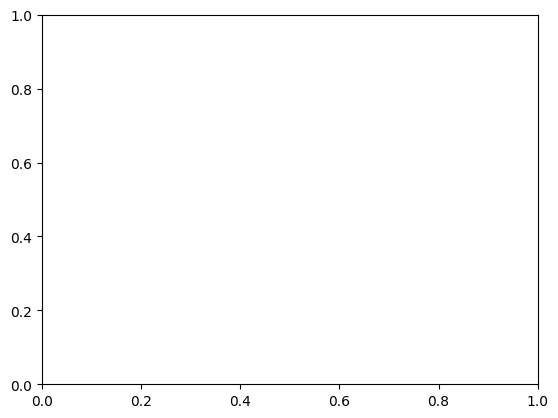

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import gymnasium as gym
from gymnasium import spaces
import matplotlib.colors as mcolors

fig, ax = plt.subplots()

In [3]:
EPISODES = 10_000
MAX_STEPS = 200
COLUMNS = 10
ROWS = 5
ACTION_MAPPINGS = {
    0: (-1, 0),  # Move up
    1: (1, 0),   # Move down
    2: (0, -1),  # Move left
    3: (0, 1)    # Move right
}


In [4]:
class GridEnv1(gym.Env):
    def __init__(self):
        super(GridEnv1, self).__init__()
        self.action_space = spaces.Discrete(4) # Up, Down, Left, Right
        self.observation_space = spaces.Box(low=np.array([0, 0]), high=np.array([ROWS - 1, COLUMNS - 1]), dtype=np.int32)
        self.reward_map = None
        self.obstacle_position = [np.random.randint(ROWS), np.random.randint(COLUMNS)]
        self.step_counter = 0
        self.total_rewards_collected = 0
        self.reset()

    def reset(self):
        self.state = np.array([0, 0]) # Starting at top-left corner
        self.initialize_reward_map()
        self.step_counter = 0  # Reset the step counter at the start of each episode
        self.total_rewards_collected = 0
        return self.state

    def initialize_reward_map(self):
        self.reward_map = np.full((ROWS, COLUMNS), 1)
        self.reward_map[self.obstacle_position[0], self.obstacle_position[1]] = -100
        # self.reward_map[self.state[0], self.state[1]] = 100  # Set the starting column to 0
        # self.reward_map[ROWS-1,0] = 100
        # self.reward_map[-1, :] = 100  # Set the bottom row to 100
            
    def reset_reward_map(self):
        self.initialize_reward_map()
        self.reward_map[0,0] = -1  # Mark the starting position

    def step(self, action):
        # Initialize done as False
        done = False
        reward = 0.
        
        
        # Update state based on action with x, y format
        delta = ACTION_MAPPINGS.get(action, (0, 0))
        new_state = np.array([self.state[0] + delta[0], self.state[1] + delta[1]])
        # if np.array_equal(new_state, prev_state):
        #     reward = -10

        # Check and handle boundary conditions
        if new_state[0] < 0 or new_state[0] >= ROWS or new_state[1] < 0 or new_state[1] >= COLUMNS:
            reward = -100
            done = True
        else:
            # Update the current state and the previous state
            self.state = new_state                  # Update the current state to new state

            self.step_counter += 1
            reward += self.calculate_reward()
            done = self.is_done()

            y = self.state[0]
            x = self.state[1]
            self.reward_map[y, x] = -1

        return self.state, reward, done, {}
            
    def calculate_reward(self):
        # Check if the agent has reached the bottom of the grid
        return self.reward_map[self.state[0], self.state[1]]        

    def is_done(self):
        # Check if all cells in the grid have been visited or if a step limit is reached
        max_steps = MAX_STEPS  # Example step limit
        count_minus_one = np.sum(self.reward_map == -1)
        count_minus_hundred = np.sum(self.reward_map == -100)
        return count_minus_one == (self.reward_map.size - 1) and count_minus_hundred == 1 or self.step_counter >= max_steps    
        
    def render(self, mode='human'):
        plt.figure(figsize=(5, 5))
        plt.imshow(self.reward_map, cmap='viridis', origin='lower')
        plt.scatter(self.state[1], self.state[0], c='red', marker='o')  # Agent's position
        plt.title("Agent's movement in Grid")
        plt.pause(0.1)  # Pause for a short period to create animation effect
        

In [5]:
class QLearningAgent1:
    def __init__(self, env, learning_rate=0.2, discount_factor=0.9, epsilon=0.1, gasoline_capacity=1000, wheat_capacity=100):
        self.env = env
        self.gasoline = gasoline_capacity  # Initial gasoline level
        self.wheat = 0  # Initial wheat level
        self.gasoline_capacity = gasoline_capacity
        self.wheat_capacity = wheat_capacity

        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.epsilon = epsilon
        self.q_table = np.zeros((ROWS, COLUMNS, env.action_space.n))

    def choose_action(self, prev_state, state, neg_reward):

        def get_new_state(action):
            delta = ACTION_MAPPINGS.get(action, (0, 0))
            return np.array([state[0] + delta[0], state[1] + delta[1]])

        def is_valid_action(action):
            new_state = get_new_state(action)
            return not np.array_equal(new_state, prev_state)
        
        def find_second_best_action(q_values):
            # Copy to avoid modifying the original array
            temp_q_values = np.copy(q_values)

            # Find the index of the best action
            best_action = np.argmax(temp_q_values)

            # Mask the best action by setting its value to negative infinity
            temp_q_values[best_action] = -np.inf

            # Find the second best action
            second_best_action = np.argmax(temp_q_values)

            return second_best_action

        action = None
        state_index = (state[0], state[1])
        if neg_reward > 3:
            # Implement logic to find the nearest positive reward
            action = self.find_nearest_positive_reward_action(state)
        elif np.random.uniform(0, 1) < self.epsilon:
            action = self.env.action_space.sample()  # Explore: random action
        else:
            action = np.argmax(self.q_table[state_index])  # Exploit: best known action

        if not is_valid_action(action):
            action = find_second_best_action(self.q_table[state_index])



        # Additional check or fallback strategy if needed
        if not is_valid_action(action):
            # Implement fallback strategy, e.g., select a random action
            action = self.env.action_space.sample()

        return action
    
    def find_nearest_positive_reward_action(self, state):
        min_distance = float('inf')
        best_action = None

        # Search the grid for the nearest positive reward
        for y in range(ROWS):
            for x in range(COLUMNS):
                if self.env.reward_map[y, x] > 0:  # Check for positive reward
                    distance = abs(state[0] - y) + abs(state[1] - x)
                    if distance < min_distance:
                        min_distance = distance
                        best_action = self.determine_action_to_reward(state, (y, x))

        return best_action

    def determine_action_to_reward(self, current_state, reward_state):
        dy = reward_state[0] - current_state[0]
        dx = reward_state[1] - current_state[1]

        if abs(dy) > abs(dx):
            return 1 if dy > 0 else 0  # Move down (1) or up (0) based on the y-difference
        else:
            return 3 if dx > 0 else 2  # Move right (3) or left (2) based on the x-difference
    
    def learn(self, state, action, reward, next_state):
        state_index = (state[0], state[1])
        next_state_index = (next_state[0], next_state[1])
        # Update rule for Q-learning
        best_next_action = np.argmax(self.q_table[next_state_index])
        td_target = reward + self.discount_factor * self.q_table[next_state_index][best_next_action]
        td_error = td_target - self.q_table[state_index][action]
        self.q_table[state_index][action] += self.learning_rate * td_error



In [6]:
class GridEnv2(gym.Env):
    def __init__(self):
        super(GridEnv2, self).__init__()
        self.action_space = spaces.Discrete(4) # Up, Down, Left, Right
        self.observation_space = spaces.Box(low=np.array([0, 0]), high=np.array([ROWS - 1, COLUMNS - 1]), dtype=np.int32)
        self.reward_map = None
        self.obstacle_position = [np.random.randint(ROWS), np.random.randint(COLUMNS)]
        self.step_counter = 0
        self.total_rewards_collected = 0
        self.reset()

    def reset(self):
        self.state = np.array([ROWS-1, COLUMNS-1]) # Starting at top-left corner
        self.initialize_reward_map()
        self.step_counter = 0  # Reset the step counter at the start of each episode
        self.total_rewards_collected = 0
        return self.state

    def initialize_reward_map(self):
        self.reward_map = np.full((ROWS, COLUMNS), 1)
        self.reward_map[self.obstacle_position[0], self.obstacle_position[1]] = -100
        # self.reward_map[self.state[0], self.state[1]] = 100  # Set the starting column to 0
        # self.reward_map[ROWS-1,0] = 100
        # self.reward_map[-1, :] = 100  # Set the bottom row to 100
            
    def reset_reward_map(self):
        self.initialize_reward_map()
        self.reward_map[ROWS-1,COLUMNS-1] = -1  # Mark the starting position

    def step(self, action):
        # Initialize done as False
        done = False
        reward = 0.
        
        
        # Update state based on action with x, y format
        delta = ACTION_MAPPINGS.get(action, (0, 0))
        new_state = np.array([self.state[0] + delta[0], self.state[1] + delta[1]])
        # if np.array_equal(new_state, prev_state):
        #     reward = -10

        # Check and handle boundary conditions
        if new_state[0] < 0 or new_state[0] >= ROWS or new_state[1] < 0 or new_state[1] >= COLUMNS:
            reward = -100
            done = True
        else:
            # Update the current state and the previous state
            self.state = new_state                  # Update the current state to new state

            self.step_counter += 1
            reward += self.calculate_reward()
            done = self.is_done()

            y = self.state[0]
            x = self.state[1]
            self.reward_map[y, x] = -1

        return self.state, reward, done, {}
            
    def calculate_reward(self):
        # Check if the agent has reached the bottom of the grid
        return self.reward_map[self.state[0], self.state[1]]        

    def is_done(self):
        # Check if all cells in the grid have been visited or if a step limit is reached
        max_steps = MAX_STEPS  # Example step limit
        count_minus_one = np.sum(self.reward_map == -1)
        count_minus_hundred = np.sum(self.reward_map == -100)
        return count_minus_one == (self.reward_map.size - 1) and count_minus_hundred == 1 or self.step_counter >= max_steps    
        
    def render(self, mode='human'):
        plt.figure(figsize=(5, 5))
        plt.imshow(self.reward_map, cmap='viridis', origin='lower')
        plt.scatter(self.state[1], self.state[0], c='red', marker='o')  # Agent's position
        plt.title("Agent's movement in Grid")
        plt.pause(0.1)  # Pause for a short period to create animation effect
        

In [7]:
class QLearningAgent2:
    def __init__(self, env, learning_rate=0.2, discount_factor=0.9, epsilon=0.1, gasoline_capacity=1000, wheat_capacity=100):
        self.env = env
        self.gasoline = gasoline_capacity  # Initial gasoline level
        self.wheat = 0  # Initial wheat level
        self.gasoline_capacity = gasoline_capacity
        self.wheat_capacity = wheat_capacity

        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.epsilon = epsilon
        self.q_table = np.zeros((ROWS, COLUMNS, env.action_space.n))

    def choose_action(self, prev_state, state, neg_reward):

        def get_new_state(action):
            delta = ACTION_MAPPINGS.get(action, (0, 0))
            return np.array([state[0] + delta[0], state[1] + delta[1]])

        def is_valid_action(action):
            new_state = get_new_state(action)
            return not np.array_equal(new_state, prev_state)
        
        def find_second_best_action(q_values):
            # Copy to avoid modifying the original array
            temp_q_values = np.copy(q_values)

            # Find the index of the best action
            best_action = np.argmax(temp_q_values)

            # Mask the best action by setting its value to negative infinity
            temp_q_values[best_action] = -np.inf

            # Find the second best action
            second_best_action = np.argmax(temp_q_values)

            return second_best_action

        action = None
        state_index = (state[0], state[1])
        if neg_reward > 3:
            # Implement logic to find the nearest positive reward
            action = self.find_nearest_positive_reward_action(state)
        elif np.random.uniform(0, 1) < self.epsilon:
            action = self.env.action_space.sample()  # Explore: random action
        else:
            action = np.argmax(self.q_table[state_index])  # Exploit: best known action

        if not is_valid_action(action):
            action = find_second_best_action(self.q_table[state_index])



        # Additional check or fallback strategy if needed
        if not is_valid_action(action):
            # Implement fallback strategy, e.g., select a random action
            action = self.env.action_space.sample()

        return action
    
    def find_nearest_positive_reward_action(self, state):
        min_distance = float('inf')
        best_action = None

        # Search the grid for the nearest positive reward
        for y in range(ROWS):
            for x in range(COLUMNS):
                if self.env.reward_map[y, x] > 0:  # Check for positive reward
                    distance = abs(state[0] - y) + abs(state[1] - x)
                    if distance < min_distance:
                        min_distance = distance
                        best_action = self.determine_action_to_reward(state, (y, x))

        return best_action

    def determine_action_to_reward(self, current_state, reward_state):
        dy = reward_state[0] - current_state[0]
        dx = reward_state[1] - current_state[1]

        if abs(dy) > abs(dx):
            return 1 if dy > 0 else 0  # Move down (1) or up (0) based on the y-difference
        else:
            return 3 if dx > 0 else 2  # Move right (3) or left (2) based on the x-difference
    
    def learn(self, state, action, reward, next_state):
        state_index = (state[0], state[1])
        next_state_index = (next_state[0], next_state[1])
        # Update rule for Q-learning
        best_next_action = np.argmax(self.q_table[next_state_index])
        td_target = reward + self.discount_factor * self.q_table[next_state_index][best_next_action]
        td_error = td_target - self.q_table[state_index][action]
        self.q_table[state_index][action] += self.learning_rate * td_error



In [8]:
def train_agent(env, agent, episodes):
    best_total_reward = -float('inf')
    best_path = []
    best_wheat_collected = []  # List to keep track of wheat collection

    for episode in range(episodes):
        state = env.reset()
        prev_state = None
        current_path = [state]
        wheat_collected = []  # List for the current episode
        done = False
        total_reward = 0
        neg_reward = 0

        while not done:
            action = agent.choose_action(prev_state, state, neg_reward)
            next_state, reward, done, _ = env.step(action)
            agent.learn(state, action, reward, next_state)
                
            total_reward += reward
            prev_state = state
            state = next_state
            current_path.append(state)

            if reward == 1:  # Check if wheat is collected
                wheat_collected.append(True)
            else:
                wheat_collected.append(False)

            if reward < 0:
                neg_reward += 1
            else: 
                neg_reward = 0

        if total_reward > best_total_reward:
            best_total_reward = total_reward
            best_path = current_path
            best_wheat_collected = wheat_collected  # Update the best wheat collection list

        if episode % 10 == 0:
            print(f"Episode {episode}: Total Reward: {total_reward}")

    return best_path, best_wheat_collected


In [9]:
# Train the agent
env1 = GridEnv1()
agent1 = QLearningAgent1(env1)
best_path1, wheat_collected1 = train_agent(env1, agent1, episodes=EPISODES)

Episode 0: Total Reward: -100
Episode 10: Total Reward: -82.0
Episode 20: Total Reward: -86.0
Episode 30: Total Reward: -75.0
Episode 40: Total Reward: -201.0
Episode 50: Total Reward: -95.0
Episode 60: Total Reward: -93.0
Episode 70: Total Reward: -86.0
Episode 80: Total Reward: -188.0
Episode 90: Total Reward: -89.0
Episode 100: Total Reward: -89.0
Episode 110: Total Reward: -210.0
Episode 120: Total Reward: -70.0
Episode 130: Total Reward: -100
Episode 140: Total Reward: -88.0
Episode 150: Total Reward: -77.0
Episode 160: Total Reward: -88.0
Episode 170: Total Reward: -80.0
Episode 180: Total Reward: -88.0
Episode 190: Total Reward: -110.0
Episode 200: Total Reward: -201.0
Episode 210: Total Reward: -94.0
Episode 220: Total Reward: -87.0
Episode 230: Total Reward: -94.0
Episode 240: Total Reward: -73.0
Episode 250: Total Reward: -97.0
Episode 260: Total Reward: -76.0
Episode 270: Total Reward: -100
Episode 280: Total Reward: -86.0
Episode 290: Total Reward: -78.0
Episode 300: Total 

In [10]:
env2 = GridEnv2()
agent2 = QLearningAgent2(env2)
best_path2, wheat_collected2 = train_agent(env2, agent2, episodes=EPISODES)

Episode 0: Total Reward: -96.0
Episode 10: Total Reward: -98.0
Episode 20: Total Reward: -73.0
Episode 30: Total Reward: -286.0
Episode 40: Total Reward: -83.0
Episode 50: Total Reward: -100
Episode 60: Total Reward: -86.0
Episode 70: Total Reward: -100
Episode 80: Total Reward: -80.0
Episode 90: Total Reward: -211.0
Episode 100: Total Reward: -93.0
Episode 110: Total Reward: -82.0
Episode 120: Total Reward: -81.0
Episode 130: Total Reward: -193.0
Episode 140: Total Reward: -79.0
Episode 150: Total Reward: -172.0
Episode 160: Total Reward: -249.0
Episode 170: Total Reward: -201.0
Episode 180: Total Reward: -77.0
Episode 190: Total Reward: -97.0
Episode 200: Total Reward: -92.0
Episode 210: Total Reward: -100
Episode 220: Total Reward: -103.0
Episode 230: Total Reward: -78.0
Episode 240: Total Reward: -73.0
Episode 250: Total Reward: -205.0
Episode 260: Total Reward: -7.0
Episode 270: Total Reward: -81.0
Episode 280: Total Reward: -94.0
Episode 290: Total Reward: -100
Episode 300: Total

In [11]:
def animation_plot(frame, state, env, ax, wheat_count):
    # Update the reward map to reflect the agent's movement
    env.reward_map[state[0], state[1]] = -1

    ax.clear()
    ax.imshow(env.reward_map, cmap=cmap, norm=norm, alpha=0.8)  # Use the custom colormap
    ax.scatter(state[1], state[0], color='red', label='Agent', s=100)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.legend()

    # Display the current position at the top of the plot
    position_text = f"Current Position: x={state[1]}, y={state[0]}"
    ax.text(0.5, 1.05, position_text, transform=ax.transAxes, ha='center', va='bottom')

    # Display the total wheat collected
    wheat_text = f"Wheat Collected: {wheat_count}"
    ax.text(0.5, 1.1, wheat_text, transform=ax.transAxes, ha='center', va='bottom', color='black')

    # Display the current frame at the bottom of the plot
    frame_text = f"Step: {frame}"
    ax.text(0.5, 0.01, frame_text, transform=ax.transAxes, ha='center', va='bottom', color='black')    



def update(frame, best_path, wheat_collected, env, ax):
    if frame < len(best_path) and frame < len(wheat_collected):
        state = best_path[frame]
        wheat_count = sum(wheat_collected[:frame + 1])  # Calculate total wheat collected up to this frame
        animation_plot(frame, state, env, ax, wheat_count)
    else:
        update.done = True  # Stop the animation when the end of the best path is reached

colors = ['black', 'green', 'white', 'yellow']  # Replace with actual colors
cmap = mcolors.ListedColormap(colors)

# Define the boundaries for these values
# The values are chosen to ensure that -100, -1, and 1 fall into separate bins
bounds = [-200, -1, 1, 200]
norm = mcolors.BoundaryNorm(bounds, cmap.N)


In [12]:
# Reset the environment and reward map to initial state
env1.reset()
env1.reset_reward_map()

# Create the animation using the best path
animation = FuncAnimation(fig, lambda frame: update(frame, best_path1, wheat_collected1, env1, ax),
                          frames=len(best_path1), interval=100)# Display the animation in Jupyter Notebook
HTML(animation.to_jshtml())


Exception ignored in: <function WeakMethod.__new__.<locals>._cb at 0x0000022E6100B1A0>
Traceback (most recent call last):
  File "c:\Users\Marco\AppData\Local\Programs\Python\Python311\Lib\weakref.py", line 60, in _cb
    callback(self)
  File "c:\Users\Marco\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\cbook.py", line 248, in _remove_proxy
    del self.callbacks[signal][cid]
        ~~~~~~~~~~~~~~^^^^^^^^
KeyError: 'changed'
Exception ignored in: <function WeakMethod.__new__.<locals>._cb at 0x0000022E61002E80>
Traceback (most recent call last):
  File "c:\Users\Marco\AppData\Local\Programs\Python\Python311\Lib\weakref.py", line 60, in _cb
    callback(self)
  File "c:\Users\Marco\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\cbook.py", line 248, in _remove_proxy
    del self.callbacks[signal][cid]
        ~~~~~~~~~~~~~~^^^^^^^^
KeyError: 'changed'
Exception ignored in: <function WeakMethod.__new__.<locals>._cb at 0x0000022E6100A660>
Trace

In [13]:
# Reset the environment and reward map to initial state
env2.reset()
env2.reset_reward_map()

# Create the animation using the best path
animation = FuncAnimation(fig, lambda frame: update(frame, best_path2, wheat_collected2, env2, ax),
                          frames=len(best_path2), interval=100)# Display the animation in Jupyter Notebook
HTML(animation.to_jshtml())


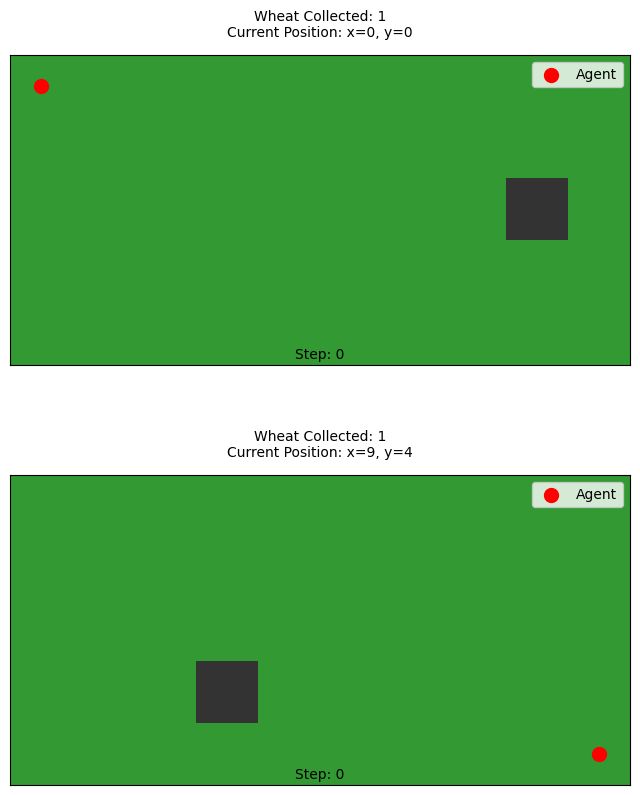

In [14]:
# Reset the environment and reward map to initial state
env1.reset()
env1.reset_reward_map()

# Reset the environment and reward map to initial state
env2.reset()
env2.reset_reward_map()

def animation_plot(frame, state, env, ax, wheat_count):
    # Update the reward map to reflect the agent's movement
    env.reward_map[state[0], state[1]] = -1

    ax.clear()
    ax.imshow(env.reward_map, cmap=cmap, norm=norm, alpha=0.8)
    ax.scatter(state[1], state[0], color='red', label='Agent', s=100)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.legend()

    position_text = f"Current Position: x={state[1]}, y={state[0]}"
    ax.text(0.5, 1.05, position_text, transform=ax.transAxes, ha='center', va='bottom')

    wheat_text = f"Wheat Collected: {wheat_count}"
    ax.text(0.5, 1.1, wheat_text, transform=ax.transAxes, ha='center', va='bottom', color='black')

    frame_text = f"Step: {frame}"
    ax.text(0.5, 0.01, frame_text, transform=ax.transAxes, ha='center', va='bottom', color='black')


def update(frame, best_path1, wheat_collected1, best_path2, wheat_collected2, env1, env2, ax1, ax2):
    wheat_count1 = sum(wheat_collected1[:frame + 1]) if frame < len(best_path1) else sum(wheat_collected1)
    wheat_count2 = sum(wheat_collected2[:frame + 1]) if frame < len(best_path2) else sum(wheat_collected2)

    if frame < len(best_path1):
        state1 = best_path1[frame]
        animation_plot(frame, state1, env1, ax1, wheat_count1)
    if frame < len(best_path2):
        state2 = best_path2[frame]
        animation_plot(frame, state2, env2, ax2, wheat_count2)

    if frame >= max(len(best_path1), len(best_path2)):
        update.done = True


# Create the figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10))

# Create the combined animation
animation = FuncAnimation(fig, lambda frame: update(frame, best_path1, wheat_collected1, best_path2, wheat_collected2, env1, env2, ax1, ax2),
                          frames=max(len(best_path1), len(best_path2)), interval=100)

# Display the animation
HTML(animation.to_jshtml())


In [20]:
tuples_list = [tuple(element) for element in best_path1]
print(tuples_list)

[(0, 0), (1, 0), (2, 0), (3, 0), (4, 0), (4, 1), (3, 1), (2, 1), (1, 1), (1, 2), (0, 2), (0, 1), (0, 0), (1, 0), (2, 0), (3, 0), (4, 0), (4, 1), (4, 2), (3, 2), (2, 2), (2, 3), (1, 3), (0, 3), (0, 4), (1, 4), (2, 4), (3, 4), (4, 4), (4, 3), (3, 3), (2, 3), (1, 3), (0, 3), (0, 4), (0, 5), (0, 6), (1, 6), (2, 6), (3, 6), (4, 6), (4, 7), (3, 7), (2, 7), (1, 7), (0, 7), (0, 8), (0, 9), (1, 9), (2, 9), (3, 9), (4, 9), (4, 8), (3, 8), (3, 7), (2, 7), (1, 7), (0, 7), (0, 8), (1, 8), (1, 7), (0, 7), (0, 8), (0, 9), (1, 9), (1, 8), (1, 7), (1, 6), (1, 5), (2, 5), (3, 5), (4, 5), (4, 6)]


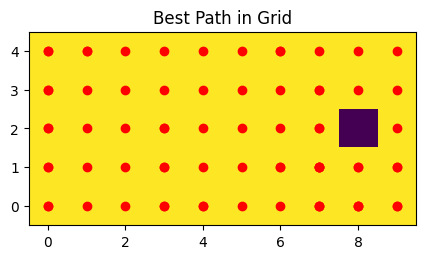

[array([0, 0]), array([1, 0]), array([2, 0]), array([3, 0]), array([4, 0]), array([4, 1]), array([3, 1]), array([2, 1]), array([1, 1]), array([1, 2]), array([0, 2]), array([0, 1]), array([0, 0]), array([1, 0]), array([2, 0]), array([3, 0]), array([4, 0]), array([4, 1]), array([4, 2]), array([3, 2]), array([2, 2]), array([2, 3]), array([1, 3]), array([0, 3]), array([0, 4]), array([1, 4]), array([2, 4]), array([3, 4]), array([4, 4]), array([4, 3]), array([3, 3]), array([2, 3]), array([1, 3]), array([0, 3]), array([0, 4]), array([0, 5]), array([0, 6]), array([1, 6]), array([2, 6]), array([3, 6]), array([4, 6]), array([4, 7]), array([3, 7]), array([2, 7]), array([1, 7]), array([0, 7]), array([0, 8]), array([0, 9]), array([1, 9]), array([2, 9]), array([3, 9]), array([4, 9]), array([4, 8]), array([3, 8]), array([3, 7]), array([2, 7]), array([1, 7]), array([0, 7]), array([0, 8]), array([1, 8]), array([1, 7]), array([0, 7]), array([0, 8]), array([0, 9]), array([1, 9]), array([1, 8]), array([1,

In [15]:
def plot_best_path(env, best_path):
    plt.figure(figsize=(5, 5))
    plt.imshow(env.reward_map, cmap='viridis', origin='lower')

    # Plot the path
    for state in best_path:
        plt.scatter(state[1], state[0], c='red', marker='o')

    plt.title("Best Path in Grid")
    plt.show()
plot_best_path(env1, best_path1)
print(best_path1)

In [16]:
# def transform_path(original_path, iteration):
#     transformed_path = []
#     ROWS = 10  # Assuming the number of rows is constant at 10

#     for x, y in original_path:
#         if iteration % 2 == 1:
#             # For odd iterations, increase x and increment y
#             new_x = x
#             new_y = y + (iteration - 1)
#         else:
#             # For even iterations, decrease x and increment y
#             new_x = ROWS - 1 - x
#             new_y = y + (iteration - 1)
        
#         transformed_path.append(np.array([new_x, new_y]))

#     # Add the last point of the iteration
#     if iteration % 2 == 1:
#         transformed_path.append(np.array([ROWS - 1, transformed_path[-1][1] + 1]))
#     else:
#         transformed_path.append(np.array([0, transformed_path[-1][1] + 1]))

#     return transformed_path

# for iteration in range(1, 4):
#     print(f"Iteration {iteration}: {transform_path(best_path1, iteration)}")

Iteration 1: [array([0, 0]), array([1, 0]), array([2, 0]), array([3, 0]), array([4, 0]), array([4, 1]), array([3, 1]), array([2, 1]), array([1, 1]), array([1, 2]), array([0, 2]), array([0, 1]), array([0, 0]), array([1, 0]), array([2, 0]), array([3, 0]), array([4, 0]), array([4, 1]), array([4, 2]), array([3, 2]), array([2, 2]), array([2, 3]), array([1, 3]), array([0, 3]), array([0, 4]), array([1, 4]), array([2, 4]), array([3, 4]), array([4, 4]), array([4, 3]), array([3, 3]), array([2, 3]), array([1, 3]), array([0, 3]), array([0, 4]), array([0, 5]), array([0, 6]), array([1, 6]), array([2, 6]), array([3, 6]), array([4, 6]), array([4, 7]), array([3, 7]), array([2, 7]), array([1, 7]), array([0, 7]), array([0, 8]), array([0, 9]), array([1, 9]), array([2, 9]), array([3, 9]), array([4, 9]), array([4, 8]), array([3, 8]), array([3, 7]), array([2, 7]), array([1, 7]), array([0, 7]), array([0, 8]), array([1, 8]), array([1, 7]), array([0, 7]), array([0, 8]), array([0, 9]), array([1, 9]), array([1, 8

In [17]:
# def plot_q_values(agent):
#     fig, axs = plt.subplots(agent.env.grid_size, agent.env.grid_size, figsize=(20, 20))

#     # Iterate over all grid cells
#     for i in range(agent.env.grid_size):
#         for j in range(agent.env.grid_size):
#             ax = axs[i, j]
#             q_values = agent.q_table[i, j]

#             # Use a bar chart or similar to represent Q-values for each action
#             ax.bar(range(len(q_values)), q_values, color=['blue', 'green', 'red', 'purple'])
#             ax.set_ylim([-100, 100])  # Assuming Q-values are in this range; adjust as needed
#             ax.set_xticks(range(len(q_values)))
#             ax.set_xticklabels(['Up', 'Down', 'Left', 'Right'])
#             ax.set_title(f"State ({i}, {j})")

#     plt.tight_layout()
#     plt.show()

# # Assuming your agent is named 'agent' and has been trained
# plot_q_values(agent)